# CCM  < STD classification with noise variables

The following example shows that CCM may not be better than STD

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

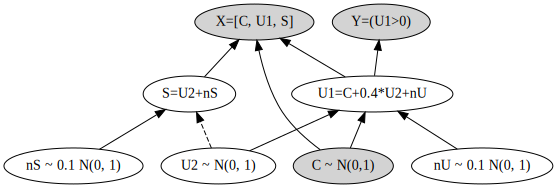

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U1, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=(U1>0)', style='filled', fillcolor='lightgray')

dot.node('nS', 'nS ~ 0.1 N(0, 1)')
dot.node('nU', 'nU ~ 0.1 N(0, 1)')

dot.node('U', 'U1=C+0.4*U2+nU')
dot.node('Z', 'U2 ~ N(0, 1)')
dot.node('S', 'S=U2+nS')


dot.edges(['UY', 'CU', 'ZU', 'UX', 'SX', 'CX'])
dot.edge('Z', 'S', style='dashed')
dot.edge('nU', 'U')
dot.edge('nS', 'S')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

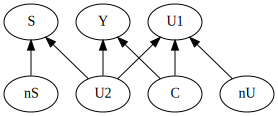

          C        U2         S        U1  Y
0  0.629645 -0.072616 -0.200372  0.838564  1
1  0.583958  1.325991  1.229762  1.262057  1
2 -0.112665 -0.051273  0.028885 -0.226757  0
3 -1.351399  0.717092  0.581243 -1.154999  0
4 -0.896147  1.201855  1.213199 -0.641358  0
5 -0.515083 -0.463340 -0.505880 -0.724741  0
6  0.586791  0.705976  0.844546  0.873404  1
7  0.589153  0.141915  0.007954  0.610520  1
8 -0.209707  1.804243  1.931309  0.517367  1
9 -0.146779  1.347881  1.442345  0.217362  1


,C,U2,S,U1,Y
0,0.186119,-0.794056,0.0,-0.115317,0
1,-0.159386,-0.356082,0.0,-0.283926,0
2,0.276922,-0.395211,0.0,0.211090,1
3,0.585250,-1.984836,0.0,-0.173400,0
4,1.100561,0.065417,0.0,1.012475,1
5,1.460078,1.247809,0.0,1.988949,1
6,0.609147,-1.150963,0.0,0.166786,1
7,-0.980187,0.737730,0.0,-0.684348,0
8,0.624281,1.542637,0.0,1.280703,1
9,0.639861,1.838353,0.0,1.246952,1


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    nU = Node('nU')
    nS = Node('nS')
    
    c = Node('C')
    u2 = Node('U2')

    s = Node('S', lambda u2, nS: u2 + nS, [u2, nS])
    u1 = Node('U1', lambda c, u2, nU: c + 0.4 * u2 + nU, [c, u2, nU])
    y  = Node('Y', lambda c, u2: (c+0.4*u2 > 0).astype(int),
              [c, u2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, nS, nU, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
a = 0.1
print(sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'nU': a*np.random.randn(n), 'nS': a*np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n), 'nU': a*np.random.randn(n), 'nS': a*np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]

In [4]:
n = 500 #100000
bs = 10
wd = 1e-4
a = 0.1
XYC = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'nU': a*np.random.randn(n), 'nS': a*np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'nU': a*np.random.randn(n), 'nS': a*np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n), 'nU': a*np.random.randn(n), 'nS': a*np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U1', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1762.61it/s]


epoch  29: loss 1.218e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1313.47it/s]


epoch  59: loss 8.180e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1313.46it/s]


epoch  89: loss 6.349e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1704.18it/s]


epoch 119: loss 5.274e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1312.75it/s]


epoch 149: loss 4.602e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1049.24it/s]


epoch 179: loss 4.164e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1311.24it/s]


epoch 209: loss 3.884e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1746.56it/s]


epoch 239: loss 3.697e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1344.60it/s]


epoch 269: loss 3.575e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1724.70it/s]


epoch 299: loss 3.487e-02


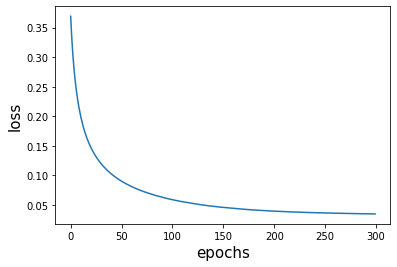

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 300
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [6]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([ 7.1936, 11.2166,  2.9124], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1163.17it/s]


epoch  29: loss 1.557e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1180.54it/s]


epoch  59: loss 1.132e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1180.32it/s]


epoch  89: loss 9.677e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1176.55it/s]


epoch 119: loss 8.916e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1166.26it/s]


epoch 149: loss 8.564e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1176.51it/s]


epoch 179: loss 8.358e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1159.77it/s]


epoch 209: loss 8.200e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 725.38it/s]


epoch 239: loss 8.068e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1098.21it/s]


epoch 269: loss 7.943e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1168.61it/s]


epoch 299: loss 7.822e-02


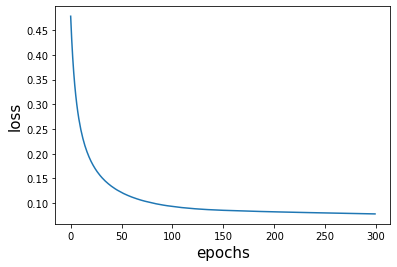

In [7]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.001 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 300
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [8]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([7.1425, 3.8295, 2.6422], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1613.06it/s]


epoch   9: loss 3.353e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1620.46it/s]


epoch  19: loss 2.869e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1679.12it/s]


epoch  29: loss 2.647e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1674.35it/s]


epoch  39: loss 2.521e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1008.49it/s]


epoch  49: loss 2.446e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1681.41it/s]


epoch  59: loss 2.402e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1677.32it/s]


epoch  69: loss 2.376e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1152.57it/s]


epoch  79: loss 2.360e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1241.49it/s]


epoch  89: loss 2.351e-01


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1692.55it/s]


epoch  99: loss 2.346e-01


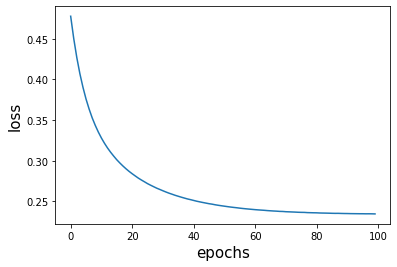

In [9]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 2]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 100
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
# [C, U, S]
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0]# , [p for p in cbm[1].classifier.parameters()]

tensor([4.6148], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1485.76it/s]


epoch  29: loss 7.909e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1493.93it/s]


epoch  59: loss 5.844e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1087.53it/s]


epoch  89: loss 4.842e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 993.52it/s]


epoch 119: loss 4.248e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1469.66it/s]


epoch 149: loss 3.876e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1122.18it/s]


epoch 179: loss 3.637e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1493.79it/s]


epoch 209: loss 3.484e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1479.19it/s]


epoch 239: loss 3.381e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1473.02it/s]


epoch 269: loss 3.308e-02


train step for 1 epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1488.44it/s]


epoch 299: loss 3.253e-02


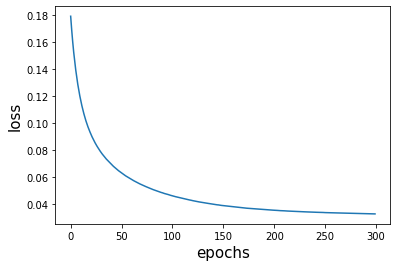

In [11]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 2])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 300
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [12]:
res.net2.classifier[0].weight[1] - res.net2.classifier[0].weight[0]

tensor([ 4.6520, 10.3549,  3.7264], grad_fn=<SubBackward0>)

In [13]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy, acc_criterion) * 100))

test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1852.28it/s]


task acc after training: 98.6%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2926.65it/s]


task acc after training: 99.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2810.03it/s]


task acc after training: 89.6%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3236.60it/s]

task acc after training: 98.8%


In [14]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2362.40it/s]


task acc after training: 99.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3249.18it/s]


task acc after training: 99.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2846.34it/s]


task acc after training: 91.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3257.61it/s]

task acc after training: 99.0%


In [15]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2287.69it/s]


task acc after training: 94.4%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3193.13it/s]


task acc after training: 92.8%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2856.92it/s]


task acc after training: 86.6%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3251.10it/s]

task acc after training: 95.4%


In [16]:
p = 0.948
n_test = 500
n = 1000
np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [5, 95])

array([0.932, 0.964])

# Regression

$$min_\theta \mathbb{E}_{(x=[c,u_1,s,1], y)} (y-\theta^T x)^2$$

where $u_1 = c + a s$ with $a \in \mathbb{R}$.

taking derivative on both sides and set to $0$ simplies to 

In [17]:
# unregularized solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((tau0/a, 1 - tau0/a, tau0, 0))

In [18]:
A

Matrix([
[              E(C^2),                 E(C)*E(S)*a + E(C^2),            E(C)*E(S),          E(C)],
[E(C)*E(S)*a + E(C^2), 2*E(C)*E(S)*a + E(C^2) + E(S^2)*a**2, E(C)*E(S) + E(S^2)*a, E(C) + E(S)*a],
[           E(C)*E(S),                 E(C)*E(S) + E(S^2)*a,               E(S^2),          E(S)],
[                E(C),                        E(C) + E(S)*a,                 E(S),             1]])

In [19]:
# unregularized CCM res solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[a*c*s], [a*a*s2 + a*c*s], [a*s2], [a*s]])
result = linsolve((A, b))
result # [C, U1, S, 1]; CCM res solution should add back 1 to the first entry

FiniteSet((-1 + tau0/a, 1 - tau0/a, tau0, 0))

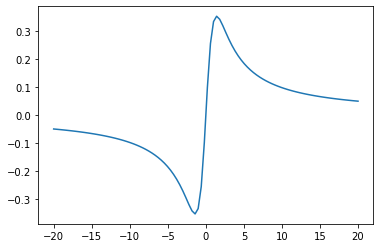

In [20]:
import matplotlib.pyplot as plt
a = np.linspace(-20, 20, 100)
plt.plot(a, 2*a / (2*a**2+4))

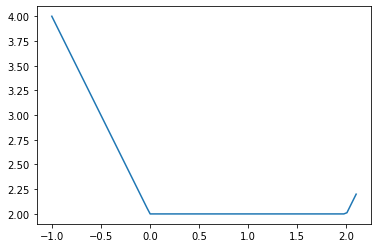

In [21]:
# l1 reg on ccm res
a = 2
t = np.linspace(min(-1, a-0.1), max(1,a+0.1), 100)
plt.plot(t, np.abs(-1 + t/a) + np.abs(1-t/a) + np.abs(t))

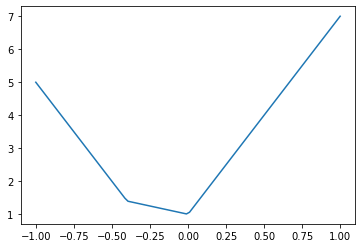

In [22]:
# l1 reg
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

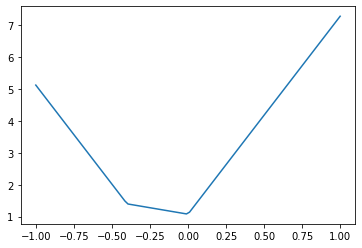

In [23]:
# l1 reg normalized
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(t/a) + np.sqrt(1+a**2) * np.abs(1-t/a) + np.abs(t))

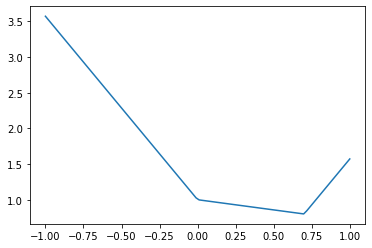

In [24]:
# weighted l1 reg
a = 0.7
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

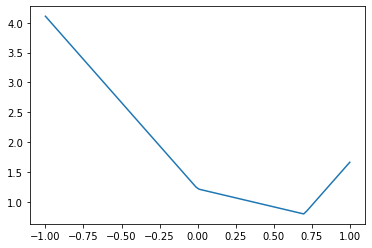

In [25]:
# weighted l1 normalized
a = 0.7
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.abs(t/a) + np.sqrt(1+a**2)*np.abs(1-t/a) + np.abs(t))

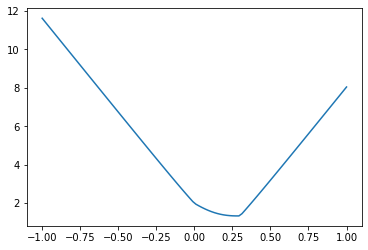

In [26]:
# EYE
a = 0.3
t = np.linspace(-1, 1, 100)
l1 = np.abs(1-t/a) + np.abs(t)
l2 = (t/a)**2
plt.plot(t, l1 + np.sqrt(l2 + l1**2))

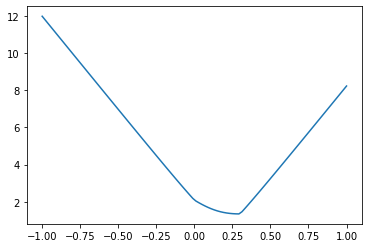

In [27]:
# EYE normalized
a = 0.3
t = np.linspace(-1, 1, 100)
l1 = np.sqrt(1+a**2) * np.abs(1-t/a) + np.abs(t)
l2 = (t/a)**2
plt.plot(t, l1 + np.sqrt(l2 + l1**2))